# Advection equation in the discontinuous Galerkin formulation

Numerical solutions obtained by the continous Galerkin (CG) formulation of PDEs dominated by advection or containing discontinuities typically struggle for stability. A discontinuous Galerkin (DG) formulation provides a better alternative.

strong form of the initial boundary value problem
$$
\begin{align*}
&\text{Find $u(\textbf{x}, t): \Omega\times[0,\infty) \to \mathbb{R}$ such that } \\
&\begin{cases}
\frac{\partial u}{\partial t}+\textbf{a}\cdot\nabla u = s & \forall(\textbf{x}, t)\in\Omega\times[0,\infty) \\
u(\textbf{x}, t=0)=u_0 & \forall\textbf{x}\in\Omega\\
u=u_{\text{I}} & \forall(\textbf{x}, t)\in\Omega_{\text{I}}\times[0,\infty)
\end{cases}~.
\end{align*}
$$

CG weak form
$$
\begin{align*}
&\text{Find $u^{n+1}\in V_{\text{CG}}$ such that } \\
&F(u^{n+1}, v)=\int_\Omega~\text{d}x~v\frac{u^{n+1} - u^n}{\Delta t^n} + v\,\mathcal{D}(\textbf{a}\cdot\nabla u) - vs=0 \quad\forall v\in V_{\text{CG}}~.
\end{align*}
$$

DG weak form assuming $\textbf{a}=\textbf{a}(\textbf{x})$
$$
\begin{align*}
&\text{Find $u^{n+1}\in V_{\text{DG}}$ such that } \\
&F(u^{n+1}, v)=\int_\Omega\text{d}\Omega~v\frac{u^{n+1} - u^n}{\Delta t^n} - \mathcal{D}(u)\nabla\cdot(v\textbf{a}) - vs \\
&+ \int_{\mathcal{F}}\text{d}\Gamma~\llbracket v\rrbracket\,\llbracket \mathcal{D}(u)\max(\textbf{a}\cdot\textbf{n}, 0)\rrbracket \\
&+ \int_{\partial\Omega_{\text{I}}}\text{d}\Gamma~vu_{\text{I}}\,\textbf{a}\cdot\textbf{n} \\
&+ \int_{\partial\Omega/\partial\Omega_{\text{I}}}\text{d}\Gamma~v\mathcal{D}(u)\,\textbf{a}\cdot\textbf{n} \\
&= 0 \quad\forall v\in V_{\text{DG}}~.
\end{align*}
$$

## Example: $d=1$ interval

problem specification
$$
\begin{cases}
\Omega = [0, L_x] \\
\textbf{a}=a\,\textbf{e}_x \\
s = 0 \\
u_0(x)=\text{H}(x_0-x) \\
u_{\text{I}} = 1
\end{cases}
$$

exact solution
$$u_{\text{exact}}(x,t) = \text{H}(x_0 + at - x)$$

In [ ]:
import numpy as np

from lucifex.mesh import interval_mesh
from lucifex.fem import Constant
from lucifex.fdm import (CN, BE, FE, 
    FiniteDifference, FunctionSeries, ConstantSeries,
    cfl_timestep)
from lucifex.solver import ibvp , BoundaryConditions, InitialBoundaryValueProblem
from lucifex.sim import run, Simulation
from lucifex.viz import plot_line
from lucifex.io import write, get_ipynb_file_name
from lucifex.pde.foundations import advection, advection_dg


def advection_simulation_1d(
    element: tuple[str, int],
    Lx: float,
    Nx: int,    
    u_in: float,
    x0: float,
    D_fdm: FiniteDifference,
    dt: float,
    a: float,
) -> InitialBoundaryValueProblem:
    mesh = interval_mesh(Lx, Nx)

    t = ConstantSeries(mesh, name='t', ics=0.0)
    dt = Constant(mesh, dt, name='dt')
    a = Constant(mesh, (a, ), name='a')

    u = FunctionSeries((mesh, *element), name='u', store=1)

    ics = lambda x: 1.0 * (x[0] <= x0) 
    bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[0], u_in),
    )

    if element == ('P', 1):
        u_solver = ibvp(advection, ics, bcs)(u, dt, a, D_fdm)
    elif element == ('DP', 0):
        u_solver = ibvp(advection_dg, ics)(u, dt, a, D_fdm)
    else:
        raise ValueError

    return Simulation([u_solver], t, dt)


Lx = 1.0
Nx = 200
h = Lx / Nx
u_in = 1.0
x0 = 0.5 * Lx

a = 1.0
courant = 0.75
dt = cfl_timestep(a, h, 1.0)

sim_1d = lambda elem, fdm: advection_simulation_1d(elem, Lx, Nx, u_in, x0, fdm, dt, a)

elem_fdm = [
    (('P', 1), CN),
    (('P', 1), BE),
    (('DP', 0), BE),
    (('DP', 0), FE),
]
simulations: dict[str, Simulation] = {
    f'{e[0]}{e[1]} {f}': sim_1d(e, f) for e, f in elem_fdm
}

n_stop = 30
[run(sim, n_stop=n_stop) for sim in simulations.values()]

results: dict[str, FunctionSeries] = {
    k: v['u'] for k, v in simulations.items()
}

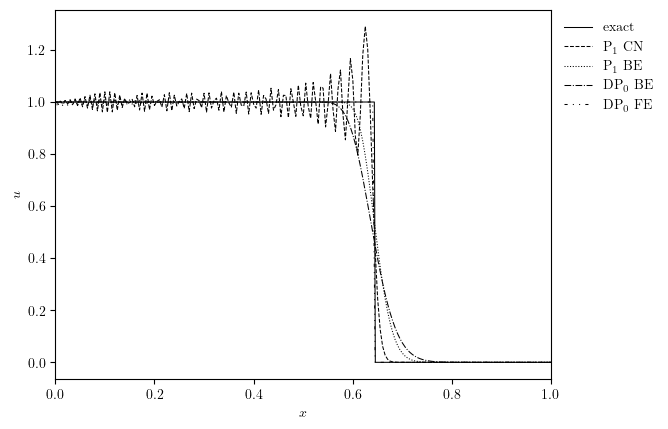

In [ ]:
def u_exact(
    x: np.ndarray, 
    t: float, 
    a: float,
    x0: float
) -> np.ndarray:
    u = np.zeros_like(x)
    u[x < x0 + a * t] = 1.0 
    return u

time_index = -1
times = [u.time_series[time_index] for u in results.values()]
assert all(np.isclose(t, times[0]) for t in times)
t = times[0]

x = np.linspace(0, Lx, num=500)
ue = u_exact(x, t, a, x0)

legend_labels = ['exact', *results.keys()]
legend_labels = [l.replace('0', '$_0$').replace('1', '$_1$') for l in legend_labels]
lines = [(x, ue), *(u.series[time_index] for u in results.values())]
fig, ax = plot_line(lines, legend_labels, x_lims=x, x_label='$x$', y_label='$u$')
write(fig, get_ipynb_file_name(), './figures', close=False, pickle=False)